In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

# Function to extract B-bit, method, and dataset from the filename

In [8]:
dataset_dim = {
    "sift": 128,
    "gist": 960,
    "openai1536": 1536,
    "openai3072": 3072,
    "msong": 420,
    "laion": 768,
}


def get_real_B_bit(dataset, method, B_bit):
    if "layer" in dataset:
        dim=128
    else:
        dim = dataset_dim[dataset]
    return (B_bit * dim + 2 * 32) / dim


def extract_B_bit_method_and_dataset(filename):
    match = re.search(r'^(.*?)_ivf[\d]+(_pca)?_b([\d.]+)_(.+?)\.csv', filename)
    if match:
        dataset = match.group(1)
        method = match.group(4)
        B_bit = get_real_B_bit(dataset, method, float(match.group(3)))
        return dataset, B_bit, method
    return None, None, None

In [9]:
# Directory containing the CSV files
csv_directory = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'saq')


## Configuration

In [10]:
# ============= Query Configuration =============
# Set plotting labels
y1_label = 'Error (%)'
y2_label = 'Recall (%)'
enable_annotation = True

# B-bit values to consider
B_bits = [1, 2, 3, 4, 5, 6, 7, 8]

# CSV columns to plot
csv_headers = ['err_q_avg_avg', 'err_q_mx_avg']

# Output file name suffix
png_name = "_saq"

# File filtering keywords
file_any_key_words1 = ["caq_adj_seg"]
file_any_key_words2 = ["sm4"]
file_exclude_words = ["index.", "topk", "1c"]
# ==========================================

## Process Data Files

In [11]:

# Get all files and sort them
file_list = [filename for filename in os.listdir(csv_directory) if filename.endswith('.csv')]
file_list.sort()  # Sort the files alphabetically

data = {}
nprobe = {}
# Process files based on configuration
for filename in file_list:
    if not any(include_word in filename for include_word in file_any_key_words1):
        continue
    if not any(include_word in filename for include_word in file_any_key_words2):
        continue
    if any(exclude_word in filename for exclude_word in file_exclude_words):
        continue
    dataset, B_bit, method = extract_B_bit_method_and_dataset(filename)
    # if B_bit not in B_bits:
    #     continue
    if B_bit is not None and method is not None and dataset is not None:
        filepath = os.path.join(csv_directory, filename)
        print("include file ", filepath)
        df = pd.read_csv(filepath)

        # Assuming each CSV file has only one row of data
        if not df.empty:
            if dataset not in data:
                data[dataset] = {}
            if method not in data[dataset]:
                data[dataset][method] = {'B_bits': [], 'recall': []}
                for header in csv_headers:
                    data[dataset][method][header] = []
            data[dataset][method]['B_bits'].append(B_bit)
            for header in csv_headers:
                if header not in df.columns:
                    if (len(data[dataset][method][header]) != 0):
                        print(f"Warning: {header} not found in {filename}")
                    data[dataset][method][header] = []
                    continue
                data[dataset][method][header].append(df[header].values[0])
            if 'recall' in df.columns:
                data[dataset][method]['recall'].append(df['recall'].values[0])
        if dataset not in nprobe:
            nprobe[dataset] = df['nprobe'].values[0]
        else:
            assert nprobe[dataset] == df['nprobe'].values[0], "nprobe mismatch across files"

include file  /home/howarli/dev/SACQ/results/saq/gist_ivf4096_b1_caq_adj_seg_pca_sm4.csv
include file  /home/howarli/dev/SACQ/results/saq/gist_ivf4096_b4_caq_adj_seg_pca_sm4.csv
include file  /home/howarli/dev/SACQ/results/saq/gist_ivf4096_b8_caq_adj_seg_pca_sm4.csv


## Generate Plots

Plot saved at  /home/howarli/dev/SACQ/results/figs/error_vs_B_bit_saq.png


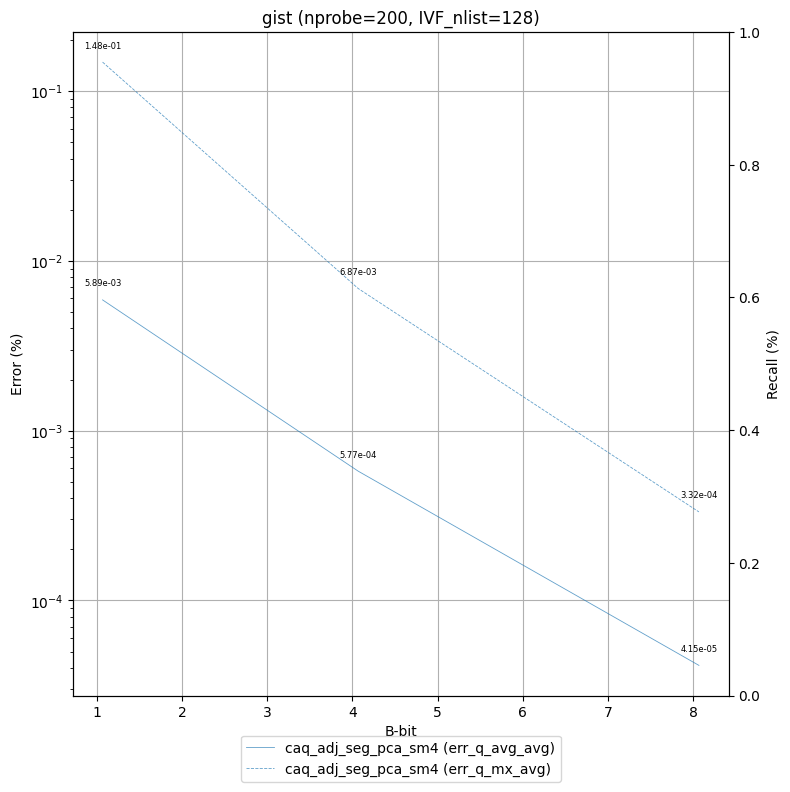

In [12]:
# Plotting
num_datasets = len(data)
fig, axs = plt.subplots(1, num_datasets, figsize=(
    8 * num_datasets, 8), sharex=True)

if num_datasets == 1:
    axs = [axs]

# Define a color map for methods to ensure consistent colors across datasets
color_map = {method: plt.cm.tab10(i) for i, method in enumerate(
    set(method for methods in data.values() for method in methods.keys()))}

# Plot for each dataset
for i, (dataset_name, methods) in enumerate(data.items()):
    ax1 = axs[i]
    ax2 = ax1.twinx()  # Create a twin Axes sharing the xaxis

    for method, values in methods.items():
        # Sort data based on B-bit
        sorted_indices = sorted(
            range(len(values['B_bits'])), key=lambda i: values['B_bits'][i])
        B_bits = [values['B_bits'][i] for i in sorted_indices]

        # move bits by PCA rate
        # if "prepca" in method:
        #     pca_rate = extract_PCA_rate(method)
        #     B_bits = [B_bit * pca_rate for B_bit in B_bits]

        x = B_bits
        # Use the consistent color for the method
        color = color_map[method]

        for header in csv_headers:
            if len(values[header]) == 0:
                continue

            header_values = [values[header][i] for i in sorted_indices]
            linestyle = '-' if header == csv_headers[0] else '--'

            # Plot the header values
            ax1.plot(x, header_values, marker='', linestyle=linestyle,
                     color=color, label=f'{method} ({header})', linewidth=0.6, alpha=0.7)

            # Annotate points with their values
            if enable_annotation:
                for j, txt in enumerate(header_values):
                    ax1.annotate(f'{txt:.2e}', (x[j], header_values[j]), textcoords="offset points", xytext=(
                        0, 10), ha='center', fontsize=6)

        if len(values['recall']) <= i:
            continue
        recall = [values['recall'][i] for i in sorted_indices]
        # Plot recall on the secondary y-axis
        ax2.plot(x, recall, marker='', linestyle=':', color=color,
                 label=f'{method} (recall)', alpha=0.7)

        # Annotate points with their values
        if enable_annotation:
            for j, txt in enumerate(recall):
                ax2.annotate(f'{txt:.2f}', (x[j], recall[j]), textcoords="offset points", xytext=(
                    0, 10), ha='center', fontsize=6)

    ax1.set_title(f'{dataset_name} (nprobe={nprobe[dataset_name]}, IVF_nlist=128)')
    ax1.set_xlabel('B-bit')
    ax1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    ax1.grid(True)
    if (len(csv_headers) > 0):
        handles1, labels1 = ax1.get_legend_handles_labels()
        by_label1 = dict(zip(labels1, handles1))

        # Combine and sort the handles and labels
        all_labels = sorted(list(by_label1.keys()))
        all_handles = [by_label1.get(label) for label in all_labels]

        ax1.legend(all_handles, all_labels, loc='upper center',
                   bbox_to_anchor=(0.5, -0.05), fancybox=True)

    else:
        handles1, labels1 = ax2.get_legend_handles_labels()
        by_label1 = dict(zip(labels1, handles1))

        # Combine and sort the handles and labels
        all_labels = sorted(list(by_label1.keys()))
        all_handles = [by_label1.get(label) for label in all_labels]

        ax2.legend(all_handles, all_labels, loc='upper center',
                   bbox_to_anchor=(0.5, -0.05), fancybox=True)
    # fig.subplots_adjust(bottom=0.2)
    # ax2.legend(loc='upper right')

    # Set y-axis to logarithmic scale
    axs[i].set_yscale('log')

# plt.xlabel('B-bit')
plt.tight_layout()
fig_path = os.path.join(os.path.dirname(os.path.abspath("__file__")), f'figs/error_vs_B_bit{png_name}.png')
# plt.savefig(fig_path)
print("Plot saved at ", fig_path)
plt.show()  # Added to display the plot in the notebook